必要なデータをメモリに載せとくためのノートブック

In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [3]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import time

import codecs
# Any results you write to the current directory are saved as output.

['train.csv', 'embeddings', 'test.csv']
CPU times: user 470 µs, sys: 429 µs, total: 899 µs
Wall time: 467 µs


**Load packages and data**

In [59]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Conv1D, MaxPool1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.layers import Dot, Lambda
from keras.layers import MaxPool1D, AveragePooling1D
from keras.layers import Add


from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 95000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

In [7]:

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, ' {punct} '.format(punct=punct))
    return x

def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [8]:
def load_and_prec():
    train_df = pd.read_csv("../input/train.csv")
    test_df = pd.read_csv("../input/test.csv")
    
    train_df["question_text"] = train_df["question_text"].str.lower()
    test_df["question_text"] = test_df["question_text"].str.lower()

    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2018) # hahaha


    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features) # 頻度順に上からmax_features子だけの単語を使う
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index

**Load embeddings**

In [9]:

def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in codecs.open(EMBEDDING_FILE, 'r', errors = 'ignore') if len(o)>100)
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]
    print(emb_mean,emb_std,"para")

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

**CNN Model**

In [10]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,)) # batch sizeを含まない
    # maxlen: 70
    # max_features: indexの数
    # embed_size: embedの次元 300 先頭できまってる
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # (batch, embeddim, input_length)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn_1d(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,)) # batch sizeを含まない
    # maxlen: 70
    # max_features: indexの数
    # embed_size: embedの次元 300 先頭できまってる
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # (batch, embeddim, input_length)
    x = Reshape((maxlen, embed_size))(x) # batch, input_length, embed_size

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool1D(pool_size=maxlen - filter_sizes[i] + 1)(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Attention layer**

In [12]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        """
        x
            None, sequence_length, units
        """
        features_dim = self.features_dim # units
        step_dim = self.step_dim # sequence_length

        eij = K.reshape(K.dot( # None, sequence_length
                        K.reshape(x, (-1, features_dim)), # None, sequence_length, units
                        K.reshape(self.W, (features_dim, 1))), # units, 1
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a) # None, sequence_length, 1
        weighted_input = x * a # None, sequence_length, units
        return K.sum(weighted_input, axis=1) # None, units

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [35]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class MultiAttention(Layer):
    def __init__(self, step_dim, n_head,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        self.n_head = n_head
        super(MultiAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], self.n_head), # units, n_head
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1], self.n_head), # seq_len, n_head
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        """
        x
            None, sequence_length, units
        """
        features_dim = self.features_dim # units
        step_dim = self.step_dim # sequence_length

        eij = K.dot( # None, sequence_length, n_head
                        x, # None, sequence_length, units
                        K.reshape(self.W, (features_dim, -1))) # units, n_head
        

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)
        

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) # None, seq_len, n_head
        
        weighted_x = Dot(axes=[1, 1])([x, a]) # None, units, n_head
        
        return Flatten()(weighted_x) # None, units * n_head

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim * self.n_head

In [40]:
class LayerNorm(Layer):
    """ Layer Normalization in the style of https://arxiv.org/abs/1607.06450 """
    def __init__(self, scale_initializer='ones', bias_initializer='zeros', **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.epsilon = 1e-6
        self.scale_initializer = initializers.get(scale_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[-1],), 
                                     initializer=self.scale_initializer,
                                     trainable=True,
                                     name='{}_scale'.format(self.name))
        self.bias = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.bias_initializer,
                                    trainable=True,
                                    name='{}_bias'.format(self.name))
        self.built = True

    def call(self, x, mask=None):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        norm = (x - mean) * (1/(std + self.epsilon))
        return norm * self.scale + self.bias

    def compute_output_shape(self, input_shape):
        return input_shape

In [55]:
class DenseLastDim(Layer):
    """ Layer Normalization in the style of https://arxiv.org/abs/1607.06450 """
    def __init__(self, out_units, **kwargs):
        self.epsilon = 1e-6
        self.out_units = out_units
        super(DenseLastDim, self).__init__(**kwargs)
        

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.out_units),
                                      initializer=initializers.get('glorot_uniform'),
                                     trainable=True,
                                     name='{}_weight'.format(self.name))
        self.bias = self.add_weight(shape=(self.out_units,),
                                    initializer='zero',
                                    trainable=True,
                                    name='{}_bias'.format(self.name))
        self.built = True

    def call(self, x, mask=None):
        """
        x: None, sequence_len, units
        """
        y = K.dot(x, self.weight) # None, seqence_len, out_units
        
        return y + self.bias 

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], self.out_units

**LSTM models**

In [13]:
def model_lstm_atten(embedding_matrix):
    
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    
    x = Attention(maxlen)(x)
    # 128 (units)
    
    x = Dense(64, activation="relu")(x)
    # 64
    
    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [28]:
def model_lstm_multi_atten(embedding_matrix):
    
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    
    x = MultiAttention(maxlen, 3)(x)
    # 128 * 3 (units)
    
    x = Dense(64, activation="relu")(x)
    # 64
    
    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [38]:
def model_lstm_multi_atten_pooling(embedding_matrix):
    
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    
    atten_x = MultiAttention(maxlen, 4)(x)
    # 128 * 4 (units)
    
    max_x = MaxPool1D(maxlen)(x) # 1, units
    max_x = Flatten()(max_x) # units
    
    ave_x = AveragePooling1D(maxlen)(x) # 1, units
    ave_x = Flatten()(ave_x) # units
    
    x = Concatenate()([atten_x, max_x, ave_x]) # units * 6
    
    x = Dense(64, activation="relu")(x)
    # 64
    
    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [67]:
def model_lstm_multi_atten_pooling_dropout(embedding_matrix):
    p_drop = 0.1
    
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    x = Dropout(p_drop)(x)
    
    x = Bidirectional(CuDNNLSTM(100, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    x = Dropout(p_drop)(x)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    x = Dropout(p_drop)(x)
    
    
    atten_x = MultiAttention(maxlen, 1)(x)
    # 128 * 4 (units)
    
    max_x = MaxPool1D(maxlen)(x) # 1, units
    max_x = Flatten()(max_x) # units
    
    ave_x = AveragePooling1D(maxlen)(x) # 1, units
    ave_x = Flatten()(ave_x) # units
    
    x = Concatenate()([atten_x, max_x, ave_x]) # units * 6

    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [87]:
l2 = 1e-5
l2 == 0.00001

True

In [90]:
def model_lstm_multi_atten_pooling_dropout_l2(embedding_matrix, reg_l2=1e-5):
    p_drop = 0.1
    l2 = regularizers.l2(reg_l2)
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True, kernel_regularizer=l2, recurrent_regularizer=l2))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    x = Dropout(p_drop)(x)
    
    x = Bidirectional(CuDNNLSTM(100, return_sequences=True, kernel_regularizer=l2, recurrent_regularizer=l2))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    x = Dropout(p_drop)(x)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True, kernel_regularizer=l2, recurrent_regularizer=l2))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    x = Dropout(p_drop)(x)
    
    
    atten_x = MultiAttention(maxlen, 1)(x)
    # 128 * 4 (units)
    
    max_x = MaxPool1D(maxlen)(x) # 1, units
    max_x = Flatten()(max_x) # units
    
    ave_x = AveragePooling1D(maxlen)(x) # 1, units
    ave_x = Flatten()(ave_x) # units
    
    x = Concatenate()([atten_x, max_x, ave_x]) # units * 6

    x = Dense(1, activation="sigmoid", kernel_regularizer=l2)(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [41]:
def model_lstm_multi_atten_pooling_layernorm(embedding_matrix):
    
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)

    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    
    x = LayerNorm()(x)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    
    x = LayerNorm()(x)
    
    
    atten_x = MultiAttention(maxlen, 4)(x)
    # 128 * 4 (units)
    
    max_x = MaxPool1D(maxlen)(x) # 1, units
    max_x = Flatten()(max_x) # units
    
    ave_x = AveragePooling1D(maxlen)(x) # 1, units
    ave_x = Flatten()(ave_x) # units
    
    x = Concatenate()([atten_x, max_x, ave_x]) # units * 6
    
    x = Dense(64, activation="relu")(x)
    # 64
    
    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [46]:
def model_lstm_multi_atten_pooling_layernorm_dropout(embedding_matrix):
    p_drop = 0.1
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    x = Dropout(p_drop)(x)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    
    x = Dropout(p_drop)(x)
    
    x = LayerNorm()(x)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    
    x = Dropout(p_drop)(x)
    
    x = LayerNorm()(x)
    
    
    atten_x = MultiAttention(maxlen, 4)(x)
    # 128 * 4 (units)
    
    max_x = MaxPool1D(maxlen)(x) # 1, units
    max_x = Flatten()(max_x) # units
    
    ave_x = AveragePooling1D(maxlen)(x) # 1, units
    ave_x = Flatten()(ave_x) # units
    
    x = Concatenate()([atten_x, max_x, ave_x]) # units * 6
    
    x = Dense(64, activation="relu")(x)
    # 64
    
    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [62]:
def model_lstm_multi_atten_pooling_layernorm_dropout_residual(embedding_matrix):
    p_drop = 0.1
    inp = Input(shape=(maxlen,))
    # maxlen
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # maxlen(sequence_length), embed_size(output_dim)
    
    skip_x = DenseLastDim(256)(x) # maxlen, 128
    
    x = Dropout(p_drop)(x)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 128(units)
    # maxlen, 256 (concat of forward and backward 128)
    
    x = Dropout(p_drop)(x)
    
    x = LayerNorm()(Add()([x, skip_x]))
    
    skip_x = x
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # CuDNNLSTM -> maxlen, 64
    # maxlen, 128 (2 * 64)
    
    x = Dropout(p_drop)(x)
    
    x = LayerNorm()(Add()([x, skip_x]))
    
    
    atten_x = MultiAttention(maxlen, 4)(x)
    # 128 * 4 (units)
    
    max_x = MaxPool1D(maxlen)(x) # 1, units
    max_x = Flatten()(max_x) # units
    
    ave_x = AveragePooling1D(maxlen)(x) # 1, units
    ave_x = Flatten()(ave_x) # units
    
    x = Concatenate()([atten_x, max_x, ave_x]) # units * 6
    
    x = Dense(64, activation="relu")(x)
    # 64
    
    x = Dense(1, activation="sigmoid")(x)
    # 1
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
def model_gru_srk_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x) # New
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model    
    

In [15]:
def model_lstm_du(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
def model_gru_atten_3(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Train and predict**

In [66]:
# https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
def train_pred(model, epochs=2):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))
    pred_train_y = model.predict([train_X], batch_size=1024, verbose=0)
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_train_y, pred_val_y, pred_test_y, model

**Main part: load, train, pred and blend**

In [18]:
%%time
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()

('Train shape : ', (1306122, 3))
('Test shape : ', (56370, 2))
CPU times: user 1min 27s, sys: 701 ms, total: 1min 27s
Wall time: 1min 28s


In [19]:
%%time
embedding_matrix_1 = load_glove(word_index)

CPU times: user 1min 21s, sys: 3.24 s, total: 1min 24s
Wall time: 1min 30s


In [20]:
embedding_matrix_1.shape

(95000, 300)

In [68]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y, model = train_pred(model_lstm_multi_atten_pooling_dropout(embedding_matrix_1), epochs = 1) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_13/Reshape_3:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_13/Tanh:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_13/div:0", shape=(?, 70, 1), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 164s 157us/step - loss: 0.1156 - acc: 0.9545 - val_loss: 0.1036 - val_acc: 0.9587
CPU times: user 2min 8s, sys: 29.5 s, total: 2min 38s
Wall time: 3min 55s


In [79]:
weights = model.get_weights()

In [84]:
np.sum([np.sum(w*2) for w in weights[1:]])

865.49854

In [91]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y, model = train_pred(model_lstm_multi_atten_pooling_dropout_l2(embedding_matrix_1), epochs = 1) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_14/Reshape_3:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_14/Tanh:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_14/div:0", shape=(?, 70, 1), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 158s 151us/step - loss: 0.1313 - acc: 0.9535 - val_loss: 0.1147 - val_acc: 0.9577
CPU times: user 2min 16s, sys: 28.3 s, total: 2min 44s
Wall time: 3min 46s


In [92]:
weights = model.get_weights()

In [93]:
np.sum([np.sum(w*2) for w in weights[1:]])

1038.14

In [94]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y, model = train_pred(model_lstm_multi_atten_pooling_dropout_l2(embedding_matrix_1, 1e-6), epochs = 1) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_15/Reshape_3:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_15/Tanh:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_15/div:0", shape=(?, 70, 1), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 161s 154us/step - loss: 0.1193 - acc: 0.9543 - val_loss: 0.1074 - val_acc: 0.9583
CPU times: user 2min 14s, sys: 28.2 s, total: 2min 42s
Wall time: 3min 50s


In [95]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y, model = train_pred(model_lstm_multi_atten_pooling_dropout_l2(embedding_matrix_1, 1e-4), epochs = 1) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_16/Reshape_3:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_16/Tanh:0", shape=(?, 70, 1), dtype=float32)
Tensor("multi_attention_16/div:0", shape=(?, 70, 1), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 162s 155us/step - loss: 0.1610 - acc: 0.9518 - val_loss: 0.1188 - val_acc: 0.9556
CPU times: user 2min 11s, sys: 28.1 s, total: 2min 39s
Wall time: 3min 53s


In [39]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_multi_atten_pooling(embedding_matrix_1), epochs = 1) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_5/Reshape_3:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_5/Tanh:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_5/div:0", shape=(?, 70, 4), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 100s 96us/step - loss: 0.1162 - acc: 0.9542 - val_loss: 0.1038 - val_acc: 0.9587
CPU times: user 1min 31s, sys: 20 s, total: 1min 51s
Wall time: 2min 27s


In [42]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_multi_atten_pooling_layernorm(embedding_matrix_1), epochs = 1) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_6/Reshape_3:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_6/Tanh:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_6/div:0", shape=(?, 70, 4), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 126s 120us/step - loss: 0.1180 - acc: 0.9537 - val_loss: 0.1042 - val_acc: 0.9585
CPU times: user 1min 49s, sys: 26.1 s, total: 2min 15s
Wall time: 3min


In [65]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_multi_atten_pooling_layernorm_dropout(embedding_matrix_1), epochs = 5) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_12/Reshape_3:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_12/Tanh:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_12/div:0", shape=(?, 70, 4), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 136s 130us/step - loss: 0.1165 - acc: 0.9543 - val_loss: 0.1042 - val_acc: 0.9582
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 133s 128us/step - loss: 0.1029 - acc: 0.9591 - val_loss: 0.0995 - val_acc: 0.9600
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 133s 127us/step - loss: 0.0975 - acc: 0.9610 - val_loss: 0.0979 - val_acc: 0.9611
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 134s 128us/step - loss: 0.0932 - acc: 0.9624 - val_loss: 0.1002 - val_acc: 0.9618
Train

In [64]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_multi_atten_pooling_layernorm_dropout_residual(embedding_matrix_1), epochs = 5) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Tensor("multi_attention_11/Reshape_3:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_11/Tanh:0", shape=(?, 70, 4), dtype=float32)
Tensor("multi_attention_11/div:0", shape=(?, 70, 4), dtype=float32)
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 184s 176us/step - loss: 0.1142 - acc: 0.9555 - val_loss: 0.1019 - val_acc: 0.9592
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 183s 176us/step - loss: 0.1007 - acc: 0.9597 - val_loss: 0.1003 - val_acc: 0.9593
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 187s 179us/step - loss: 0.0948 - acc: 0.9619 - val_loss: 0.0985 - val_acc: 0.9607
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 187s 179us/step - loss: 0.0897 - acc: 0.9637 - val_loss: 0.0971 - val_acc: 0.9607
Train

In [142]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_gru_atten_3(embedding_matrix_1), epochs = 3)
outputs[1] = [pred_train_y, pred_val_y, pred_test_y, '

-glov-e3']

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 118s 113us/step - loss: 0.1140 - acc: 0.9552 - val_loss: 0.1033 - val_acc: 0.9584
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 116s 111us/step - loss: 0.1008 - acc: 0.9599 - val_loss: 0.1000 - val_acc: 0.9601
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.0947 - acc: 0.9623 - val_loss: 0.0981 - val_acc: 0.9608
CPU times: user 4min 25s, sys: 1min 11s, total: 5min 37s
Wall time: 6min 36s


In [143]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_gru_atten_3(embedding_matrix_3), epochs = 3)
outputs[2] = [pred_train_y, pred_val_y, pred_test_y, '3-GRU-atten-parag-3']

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 120s 115us/step - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1058 - val_acc: 0.9579
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 119s 114us/step - loss: 0.1013 - acc: 0.9599 - val_loss: 0.1015 - val_acc: 0.9598
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 120s 115us/step - loss: 0.0932 - acc: 0.9628 - val_loss: 0.1022 - val_acc: 0.9600
CPU times: user 4min 33s, sys: 1min 14s, total: 5min 47s
Wall time: 6min 48s


In [28]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_du(embedding_matrix_5), epochs = 2)
outputs.append([pred_train_y, pred_val_y, pred_test_y, 'LSTM-DU-all'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 67s 64us/step - loss: 0.1131 - acc: 0.9559 - val_loss: 0.1004 - val_acc: 0.9598
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 67s 64us/step - loss: 0.0896 - acc: 0.9637 - val_loss: 0.1000 - val_acc: 0.9601
CPU times: user 1min 48s, sys: 39.4 s, total: 2min 28s
Wall time: 2min 28s


In [29]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_1), epochs = 3)
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2-LSTM-attention-glov'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 91s 87us/step - loss: 0.1178 - acc: 0.9538 - val_loss: 0.1037 - val_acc: 0.9585
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.1019 - acc: 0.9595 - val_loss: 0.1019 - val_acc: 0.9588
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.0954 - acc: 0.9618 - val_loss: 0.1008 - val_acc: 0.9606
CPU times: user 3min 28s, sys: 58.9 s, total: 4min 27s
Wall time: 5min 10s


In [30]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_4), epochs = 3)
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2-LSTM-attention-glov+parag'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 91s 87us/step - loss: 0.1188 - acc: 0.9541 - val_loss: 0.1067 - val_acc: 0.9570
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.1015 - acc: 0.9597 - val_loss: 0.1025 - val_acc: 0.9593
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 91s 87us/step - loss: 0.0947 - acc: 0.9622 - val_loss: 0.0975 - val_acc: 0.9608
CPU times: user 3min 29s, sys: 59.5 s, total: 4min 28s
Wall time: 5min 10s


## ただの平均

0.6657290729072908
0.6875294394724447
0.6744871492572506
0.6761391195183886
0.6836038309342204
0.6834307540945657


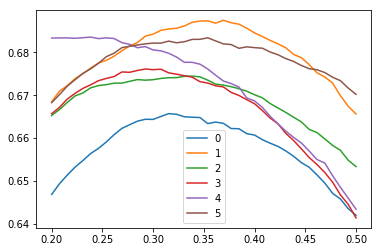

In [166]:
for i, val_proba_y in enumerate([o[1] for o in outputs]):
    f1_list = []
    for thr in np.linspace(0.2, 0.5, 40):
        f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

    plt.plot(np.linspace(0.2, 0.5, 40), f1_list, label=i)

    print(max(f1_list))
    np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]
plt.legend()

0.6995329527763362


0.3153846153846154

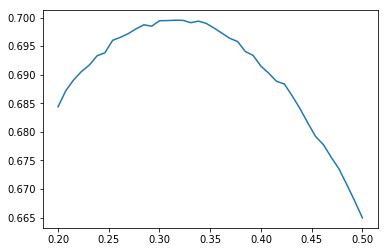

In [167]:
val_proba_y = pred_val_array.mean(axis=1)
lr_clf.coef_

f1_list = []
for thr in np.linspace(0.2, 0.5, 40):
    f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

plt.plot(np.linspace(0.2, 0.5, 40), f1_list)

print(max(f1_list))
np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]

In [179]:
np.median(np.random.dirichlet((1, 1, 1, 1, 1, 1), 100))

0.13310769909884657

In [180]:
np.median(np.random.dirichlet([0.9]*6, 100))

0.12144312611605358

In [181]:
np.median(np.random.dirichlet([0.8]*6, 100))

0.12587568300878793

In [182]:
np.median(np.random.dirichlet([2]*6, 100))

0.14205151059259596

In [183]:
np.median(np.random.dirichlet([3]*6, 100))

0.1559600109713981

In [194]:
np.median(np.random.dirichlet([4]*6, 100))

0.15965241997811833

In [201]:
max_f1_list = []
thr_list = []
i = 0
diri_weights = np.random.dirichlet([3]*6, 1000)
for weight in diri_weights:
    print(i)
    i = i+1
    val_proba_y = np.dot(pred_val_array, weight) 
    f1_list = []
    for thr in np.linspace(0.2, 0.5, 40):
        f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))
    
    max_f1_list.append(max(f1_list))
    thr_list.append(np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
         1.,  2.,  0.,  2.,  0.,  3.,  2.,  2.,  0.,  0.,  2.,  1.,  4.,
         6.,  3., 10.,  3.,  4.,  7.,  9.,  4.,  6.,  9.,  6.,  7., 12.,
        12., 10., 13., 13., 22., 16., 14., 18., 32., 24., 21., 20., 39.,
        39., 34., 36., 46., 36., 52., 72., 49., 34., 55., 36., 29., 29.,
        22., 21.,  6., 11.,  5.,  3.,  4.,  3.,  4.]),
 array([0.69170326, 0.69179192, 0.69188059, 0.69196926, 0.69205792,
        0.69214659, 0.69223525, 0.69232392, 0.69241259, 0.69250125,
        0.69258992, 0.69267858, 0.69276725, 0.69285592, 0.69294458,
        0.69303325, 0.69312191, 0.69321058, 0.69329925, 0.69338791,
        0.69347658, 0.69356524, 0.69365391, 0.69374257, 0.69383124,
        0.69391991, 0.69400857, 0.69409724, 0.6941859 , 0.69427457,
        0.69436324, 0.6944

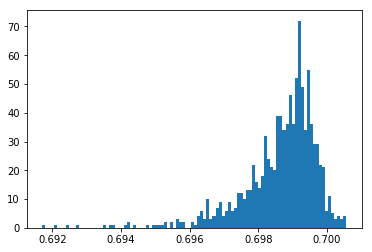

In [203]:
plt.hist(max_f1_list, bins=100)

In [204]:
diri_weights[np.argmax(max_f1_list)]

array([0.217583  , 0.1619671 , 0.20209407, 0.14746982, 0.13832512,
       0.13256088])

In [205]:
thr_list[np.argmax(max_f1_list)]

0.3153846153846154

In [206]:
max(max_f1_list)

0.7005698497668796

In [208]:
import optuna

In [213]:
def objective(trial):
    w_list = []
    for i in range(6):
        w_list.append(trial.suggest_uniform('w{}'.format(i), 0, 0.5))
    
    w_normed = np.array(w_list) / np.sum(w_list)
    val_proba_y = np.dot(pred_val_array, w_normed)
    f1_list = []
    for thr in np.linspace(0.2, 0.5, 40):
        f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))
    
    return - max(f1_list)

In [217]:
study = optuna.create_study()
    
study.optimize(objective, n_trials=1000)

[I 2018-12-23 13:22:20,247] Finished a trial resulted in value: -0.696678068294. Current best value is -0.696678068294 with parameters: {'w5': 0.45327601507917586, 'w4': 0.0006107505524340917, 'w3': 0.375715987558311, 'w2': 0.32598856708969853, 'w1': 0.12267456992166803, 'w0': 0.03685329891539263}.
[I 2018-12-23 13:22:21,228] Finished a trial resulted in value: -0.697297610092. Current best value is -0.697297610092 with parameters: {'w5': 0.2883292346929431, 'w4': 0.19304806333029162, 'w3': 0.3285048796677579, 'w2': 0.4954484209896376, 'w1': 0.23119962320663578, 'w0': 0.003578819577987391}.
[I 2018-12-23 13:22:22,273] Finished a trial resulted in value: -0.695647157239. Current best value is -0.697297610092 with parameters: {'w5': 0.2883292346929431, 'w4': 0.19304806333029162, 'w3': 0.3285048796677579, 'w2': 0.4954484209896376, 'w1': 0.23119962320663578, 'w0': 0.003578819577987391}.
[I 2018-12-23 13:22:23,339] Finished a trial resulted in value: -0.698522924552. Current best value is -

[I 2018-12-23 13:22:47,362] Finished a trial resulted in value: -0.700619528228. Current best value is -0.700619528228 with parameters: {'w5': 0.415604085764253, 'w4': 0.3524013042748392, 'w3': 0.4832535032525501, 'w2': 0.17825443431227278, 'w1': 0.30840085384088206, 'w0': 0.22261668022469247}.
[I 2018-12-23 13:22:48,335] Finished a trial resulted in value: -0.7. Current best value is -0.700619528228 with parameters: {'w5': 0.415604085764253, 'w4': 0.3524013042748392, 'w3': 0.4832535032525501, 'w2': 0.17825443431227278, 'w1': 0.30840085384088206, 'w0': 0.22261668022469247}.
[I 2018-12-23 13:22:49,309] Finished a trial resulted in value: -0.699579770196. Current best value is -0.700619528228 with parameters: {'w5': 0.415604085764253, 'w4': 0.3524013042748392, 'w3': 0.4832535032525501, 'w2': 0.17825443431227278, 'w1': 0.30840085384088206, 'w0': 0.22261668022469247}.
[I 2018-12-23 13:22:50,282] Finished a trial resulted in value: -0.700008723212. Current best value is -0.700619528228 with

[I 2018-12-23 13:23:14,199] Finished a trial resulted in value: -0.700172297988. Current best value is -0.700830782685 with parameters: {'w5': 0.3810819611052193, 'w4': 0.4088266990087927, 'w3': 0.4642358883107166, 'w2': 0.20786365845917112, 'w1': 0.3590755697823451, 'w0': 0.17857467181883793}.
[I 2018-12-23 13:23:15,179] Finished a trial resulted in value: -0.697975157393. Current best value is -0.700830782685 with parameters: {'w5': 0.3810819611052193, 'w4': 0.4088266990087927, 'w3': 0.4642358883107166, 'w2': 0.20786365845917112, 'w1': 0.3590755697823451, 'w0': 0.17857467181883793}.
[I 2018-12-23 13:23:16,169] Finished a trial resulted in value: -0.699809457821. Current best value is -0.700830782685 with parameters: {'w5': 0.3810819611052193, 'w4': 0.4088266990087927, 'w3': 0.4642358883107166, 'w2': 0.20786365845917112, 'w1': 0.3590755697823451, 'w0': 0.17857467181883793}.
[I 2018-12-23 13:23:17,184] Finished a trial resulted in value: -0.700144969556. Current best value is -0.700830

[I 2018-12-23 13:23:43,114] Finished a trial resulted in value: -0.699499829487. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:23:44,129] Finished a trial resulted in value: -0.698613725826. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:23:45,142] Finished a trial resulted in value: -0.699076072878. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:23:46,279] Finished a trial resulted in value: -0.700049376979. Current best value is -0.701106

[I 2018-12-23 13:24:12,128] Finished a trial resulted in value: -0.699294947121. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:24:13,202] Finished a trial resulted in value: -0.699125654297. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:24:14,210] Finished a trial resulted in value: -0.699102809237. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:24:15,219] Finished a trial resulted in value: -0.697487141807. Current best value is -0.701106

[I 2018-12-23 13:24:40,476] Finished a trial resulted in value: -0.699644169632. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:24:41,496] Finished a trial resulted in value: -0.699126797977. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:24:42,517] Finished a trial resulted in value: -0.698202189385. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:24:43,535] Finished a trial resulted in value: -0.698950533407. Current best value is -0.701106

[I 2018-12-23 13:25:08,139] Finished a trial resulted in value: -0.700102654348. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:25:09,179] Finished a trial resulted in value: -0.699956197985. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:25:10,244] Finished a trial resulted in value: -0.700263388938. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:25:11,308] Finished a trial resulted in value: -0.699759622346. Current best value is -0.701106

[I 2018-12-23 13:25:36,191] Finished a trial resulted in value: -0.699638610399. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:25:37,268] Finished a trial resulted in value: -0.698320450979. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:25:38,306] Finished a trial resulted in value: -0.699883923389. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:25:39,372] Finished a trial resulted in value: -0.698953802751. Current best value is -0.701106

[I 2018-12-23 13:26:04,813] Finished a trial resulted in value: -0.699773084308. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:26:05,870] Finished a trial resulted in value: -0.69911810479. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:26:06,925] Finished a trial resulted in value: -0.699815298015. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:26:07,988] Finished a trial resulted in value: -0.699953035106. Current best value is -0.7011067

[I 2018-12-23 13:26:33,519] Finished a trial resulted in value: -0.70021805495. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:26:34,665] Finished a trial resulted in value: -0.699260286639. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:26:35,756] Finished a trial resulted in value: -0.699904676623. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:26:36,850] Finished a trial resulted in value: -0.699770462272. Current best value is -0.7011067

[I 2018-12-23 13:27:03,446] Finished a trial resulted in value: -0.700393184797. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:27:04,520] Finished a trial resulted in value: -0.69957131271. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:27:05,594] Finished a trial resulted in value: -0.69998547989. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:27:06,919] Finished a trial resulted in value: -0.700163303394. Current best value is -0.70110679

[I 2018-12-23 13:27:32,900] Finished a trial resulted in value: -0.700046821959. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:27:33,974] Finished a trial resulted in value: -0.700326302296. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:27:35,049] Finished a trial resulted in value: -0.699776128196. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:27:36,121] Finished a trial resulted in value: -0.700267410766. Current best value is -0.701106

[I 2018-12-23 13:28:03,209] Finished a trial resulted in value: -0.700163685257. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:28:04,434] Finished a trial resulted in value: -0.7. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:28:05,697] Finished a trial resulted in value: -0.699487360792. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:28:06,951] Finished a trial resulted in value: -0.699358332843. Current best value is -0.701106795549 with

[I 2018-12-23 13:28:35,895] Finished a trial resulted in value: -0.700177547516. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:28:37,097] Finished a trial resulted in value: -0.698965517241. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:28:38,621] Finished a trial resulted in value: -0.699440096151. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:28:39,837] Finished a trial resulted in value: -0.698861179184. Current best value is -0.701106

[I 2018-12-23 13:29:09,107] Finished a trial resulted in value: -0.700940879913. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:29:10,341] Finished a trial resulted in value: -0.699272504163. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:29:11,573] Finished a trial resulted in value: -0.699542857143. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:29:12,789] Finished a trial resulted in value: -0.699496133115. Current best value is -0.701106

[I 2018-12-23 13:29:42,419] Finished a trial resulted in value: -0.700685854974. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:29:43,651] Finished a trial resulted in value: -0.700096771356. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:29:44,889] Finished a trial resulted in value: -0.700401559681. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:29:46,128] Finished a trial resulted in value: -0.700395488502. Current best value is -0.701106

[I 2018-12-23 13:30:16,223] Finished a trial resulted in value: -0.700666099357. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:30:17,459] Finished a trial resulted in value: -0.700495122023. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:30:18,731] Finished a trial resulted in value: -0.69824880467. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:30:19,975] Finished a trial resulted in value: -0.700130567242. Current best value is -0.7011067

[I 2018-12-23 13:30:49,970] Finished a trial resulted in value: -0.699705221376. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:30:51,221] Finished a trial resulted in value: -0.700442984129. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:30:52,484] Finished a trial resulted in value: -0.699221265882. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:30:53,742] Finished a trial resulted in value: -0.70001161845. Current best value is -0.7011067

[I 2018-12-23 13:31:24,070] Finished a trial resulted in value: -0.700035104142. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:31:25,350] Finished a trial resulted in value: -0.699842114496. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:31:26,611] Finished a trial resulted in value: -0.699828473413. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:31:27,873] Finished a trial resulted in value: -0.700300545651. Current best value is -0.701106

[I 2018-12-23 13:31:58,552] Finished a trial resulted in value: -0.699573781822. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:31:59,831] Finished a trial resulted in value: -0.70005195405. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:32:01,112] Finished a trial resulted in value: -0.700551776487. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:32:02,389] Finished a trial resulted in value: -0.699423487753. Current best value is -0.7011067

[I 2018-12-23 13:32:33,305] Finished a trial resulted in value: -0.700686031236. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:32:34,594] Finished a trial resulted in value: -0.698795180723. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:32:35,885] Finished a trial resulted in value: -0.700390465645. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:32:37,182] Finished a trial resulted in value: -0.700322486074. Current best value is -0.701106

[I 2018-12-23 13:33:08,573] Finished a trial resulted in value: -0.697932160877. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:33:09,882] Finished a trial resulted in value: -0.70034771937. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:33:11,184] Finished a trial resulted in value: -0.700515899618. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:33:12,491] Finished a trial resulted in value: -0.697968213308. Current best value is -0.7011067

[I 2018-12-23 13:33:44,144] Finished a trial resulted in value: -0.700587889477. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:33:45,457] Finished a trial resulted in value: -0.699917946313. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:33:46,770] Finished a trial resulted in value: -0.699906803355. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:33:48,079] Finished a trial resulted in value: -0.700527859238. Current best value is -0.701106

[I 2018-12-23 13:34:20,070] Finished a trial resulted in value: -0.699979781058. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:34:21,390] Finished a trial resulted in value: -0.700501399254. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:34:22,716] Finished a trial resulted in value: -0.700480139677. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:34:24,045] Finished a trial resulted in value: -0.699721285023. Current best value is -0.701106

[I 2018-12-23 13:34:56,101] Finished a trial resulted in value: -0.699479580136. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:34:57,437] Finished a trial resulted in value: -0.700492524699. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:34:58,777] Finished a trial resulted in value: -0.70034236639. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:35:00,120] Finished a trial resulted in value: -0.699921468253. Current best value is -0.7011067

[I 2018-12-23 13:35:32,729] Finished a trial resulted in value: -0.699155483572. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:35:34,085] Finished a trial resulted in value: -0.700090360568. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:35:35,445] Finished a trial resulted in value: -0.69948033542. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:35:36,805] Finished a trial resulted in value: -0.699419383653. Current best value is -0.7011067

[I 2018-12-23 13:36:09,832] Finished a trial resulted in value: -0.70006742693. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:36:11,232] Finished a trial resulted in value: -0.700866754811. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:36:12,596] Finished a trial resulted in value: -0.699859747546. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:36:13,971] Finished a trial resulted in value: -0.700397753861. Current best value is -0.7011067

[I 2018-12-23 13:36:47,006] Finished a trial resulted in value: -0.699025787966. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:36:48,376] Finished a trial resulted in value: -0.700569592522. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:36:49,759] Finished a trial resulted in value: -0.69966804496. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:36:51,145] Finished a trial resulted in value: -0.700196895993. Current best value is -0.7011067

[I 2018-12-23 13:37:24,649] Finished a trial resulted in value: -0.700656646724. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:37:26,041] Finished a trial resulted in value: -0.699535930249. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:37:27,429] Finished a trial resulted in value: -0.700498731298. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:37:28,816] Finished a trial resulted in value: -0.699731666323. Current best value is -0.701106

[I 2018-12-23 13:38:02,299] Finished a trial resulted in value: -0.699071329777. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:38:03,715] Finished a trial resulted in value: -0.699602465864. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:38:05,131] Finished a trial resulted in value: -0.701036345059. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:38:06,542] Finished a trial resulted in value: -0.700925574469. Current best value is -0.701106

[I 2018-12-23 13:38:40,564] Finished a trial resulted in value: -0.700017501896. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:38:41,977] Finished a trial resulted in value: -0.699923614783. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:38:43,389] Finished a trial resulted in value: -0.700532425591. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:38:44,804] Finished a trial resulted in value: -0.700196717461. Current best value is -0.701106

[I 2018-12-23 13:39:19,065] Finished a trial resulted in value: -0.700404976255. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:39:20,520] Finished a trial resulted in value: -0.70059040159. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:39:21,968] Finished a trial resulted in value: -0.700196371523. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:39:23,431] Finished a trial resulted in value: -0.700203429236. Current best value is -0.7011067

[I 2018-12-23 13:39:58,287] Finished a trial resulted in value: -0.7003396325. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:39:59,745] Finished a trial resulted in value: -0.700458407545. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:40:01,216] Finished a trial resulted in value: -0.700234466589. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:40:02,666] Finished a trial resulted in value: -0.700058788948. Current best value is -0.70110679

[I 2018-12-23 13:40:37,439] Finished a trial resulted in value: -0.699435938759. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:40:38,908] Finished a trial resulted in value: -0.700389105058. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:40:40,361] Finished a trial resulted in value: -0.700333352828. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:40:41,879] Finished a trial resulted in value: -0.700046931832. Current best value is -0.701106

[I 2018-12-23 13:41:17,173] Finished a trial resulted in value: -0.699769850403. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:41:18,657] Finished a trial resulted in value: -0.698944219096. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:41:20,124] Finished a trial resulted in value: -0.699093997735. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:41:21,589] Finished a trial resulted in value: -0.699631865705. Current best value is -0.701106

[I 2018-12-23 13:41:57,119] Finished a trial resulted in value: -0.700405922378. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:41:58,600] Finished a trial resulted in value: -0.700591092644. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:42:00,077] Finished a trial resulted in value: -0.700455713952. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:42:01,566] Finished a trial resulted in value: -0.69979439956. Current best value is -0.7011067

[I 2018-12-23 13:42:37,655] Finished a trial resulted in value: -0.700651837128. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:42:39,178] Finished a trial resulted in value: -0.699866271295. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:42:40,681] Finished a trial resulted in value: -0.700134573752. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.
[I 2018-12-23 13:42:42,177] Finished a trial resulted in value: -0.700105969622. Current best value is -0.701106

[I 2018-12-23 13:43:18,502] Finished a trial resulted in value: -0.698817210445. Current best value is -0.701106795549 with parameters: {'w5': 0.3439965157733161, 'w4': 0.3973638377623718, 'w3': 0.45367051715007306, 'w2': 0.2531439484928336, 'w1': 0.2708216404323344, 'w0': 0.15633855386143702}.


In [218]:
study.best_params

{'w0': 0.15633855386143702,
 'w1': 0.2708216404323344,
 'w2': 0.2531439484928336,
 'w3': 0.45367051715007306,
 'w4': 0.3973638377623718,
 'w5': 0.3439965157733161}

In [224]:
weights = [study.best_params['w{}'.format(i)] for i in range(6)]

In [225]:
w_normed = np.array(weights) / np.sum(weights)

In [226]:
w_normed

array([0.08336567, 0.14441241, 0.13498599, 0.24191439, 0.21188952,
       0.18343203])

In [227]:
val_proba_y = np.dot(pred_val_array, w_normed)
f1_list = []
for thr in np.linspace(0.2, 0.5, 40):
    f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))
np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]

0.3230769230769231

In [228]:
max(f1_list)

0.7011067955494554

In [219]:
study.best_value

-0.7011067955494554

In [229]:
test_proba_y_array =  np.concatenate([o[1] for o in outputs], axis=1)
test_proba_y = np.dot(pred_val_array,np.array([0.08336567, 0.14441241, 0.13498599, 0.24191439, 0.21188952,
       0.18343203]))

pred_test_y = test_proba_y > 0.323

In [231]:
pred_test_y

array([False, False, False, ...,  True, False, False])

In [232]:
np.save('../mydata/1d-CNN-fasttext,3-GRU-atten-glov-e3,3-GRU-atten-parag-e3,LSTM-DU-all,2-LSTM-attention-glov,2-LSTM-attention-glov+parag-train.npy', pred_train_array)

np.save('../mydata/1d-CNN-fasttext,3-GRU-atten-glov-e3,3-GRU-atten-parag-e3,LSTM-DU-all,2-LSTM-attention-glov,2-LSTM-attention-glov+parag-val.npy', pred_val_array)